<b>Target :</b> 

```1. Add Batch Normalization to increase model efficiency  ```

In [2]:
!pip install torchsummary
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [4]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [6]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

def model_summary():
  model = Net().to(device)
  summary(model, input_size=(1, 28, 28))



cuda


In [7]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [8]:
def plot_result():
  fig, axs = plt.subplots(2,2,figsize=(15,10))
  axs[0, 0].plot(train_losses)
  axs[0, 0].set_title("Training Loss")
  axs[1, 0].plot(train_acc)
  axs[1, 0].set_title("Training Accuracy")
  axs[0, 1].plot(test_losses)
  axs[0, 1].set_title("Test Loss")
  axs[1, 1].plot(test_acc)
  axs[1, 1].set_title("Test Accuracy")

In [9]:
class Net(nn.Module):

    def conv_block (self, in_channels, out_channels, kernel_size, padding = 1) :
      return nn.Sequential(
            nn.Conv2d (in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size, padding = padding, bias = False),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels))
        
    def out_block(self, in_channels, kernel_size = 1):
      return nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=10, kernel_size = kernel_size, padding = 0, bias = False))


    def __init__(self):
      super(Net, self).__init__()
      self.conv1 = self.conv_block(1, 10, 3)
      self.conv2 = self.conv_block(10, 10, 3, 0)
      self.conv3 = self.conv_block(10, 11, 3)
      self.conv4 = self.conv_block(11, 11, 3, 0)
      self.conv5 = self.conv_block(11, 12, 3)
      self.conv6 = self.conv_block(12, 12, 3, 0)
      self.conv7 = self.out_block(12, 3)
      self.pool = nn.MaxPool2d(2, 2)
        

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pool(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

model_summary() 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]              90
              ReLU-2           [-1, 10, 28, 28]               0
       BatchNorm2d-3           [-1, 10, 28, 28]              20
            Conv2d-4           [-1, 10, 26, 26]             900
              ReLU-5           [-1, 10, 26, 26]               0
       BatchNorm2d-6           [-1, 10, 26, 26]              20
         MaxPool2d-7           [-1, 10, 13, 13]               0
            Conv2d-8           [-1, 11, 13, 13]             990
              ReLU-9           [-1, 11, 13, 13]               0
      BatchNorm2d-10           [-1, 11, 13, 13]              22
           Conv2d-11           [-1, 11, 11, 11]           1,089
             ReLU-12           [-1, 11, 11, 11]               0
      BatchNorm2d-13           [-1, 11, 11, 11]              22
        MaxPool2d-14             [-1, 1

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.040861815214157104 Batch_id=468 Accuracy=95.30: 100%|██████████| 469/469 [00:19<00:00, 23.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0541, Accuracy: 9826/10000 (98.26%)

EPOCH: 1


Loss=0.019281387329101562 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:21<00:00, 22.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0410, Accuracy: 9866/10000 (98.66%)

EPOCH: 2


Loss=0.012392560951411724 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:19<00:00, 23.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0384, Accuracy: 9873/10000 (98.73%)

EPOCH: 3


Loss=0.010184317827224731 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:20<00:00, 22.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0325, Accuracy: 9890/10000 (98.90%)

EPOCH: 4


Loss=0.007081593852490187 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:20<00:00, 23.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9902/10000 (99.02%)

EPOCH: 5


Loss=0.003062300384044647 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:21<00:00, 22.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0331, Accuracy: 9901/10000 (99.01%)

EPOCH: 6


Loss=0.01309912744909525 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:20<00:00, 23.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9923/10000 (99.23%)

EPOCH: 7


Loss=0.0028247255831956863 Batch_id=468 Accuracy=99.45: 100%|██████████| 469/469 [00:20<00:00, 22.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9904/10000 (99.04%)

EPOCH: 8


Loss=0.014048225246369839 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:20<00:00, 22.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0257, Accuracy: 9918/10000 (99.18%)

EPOCH: 9


Loss=0.008154093287885189 Batch_id=468 Accuracy=99.54: 100%|██████████| 469/469 [00:20<00:00, 22.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9916/10000 (99.16%)

EPOCH: 10


Loss=0.0016934649320319295 Batch_id=468 Accuracy=99.61: 100%|██████████| 469/469 [00:20<00:00, 22.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Accuracy: 9902/10000 (99.02%)

EPOCH: 11


Loss=0.09441175311803818 Batch_id=468 Accuracy=99.69: 100%|██████████| 469/469 [00:20<00:00, 22.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 9910/10000 (99.10%)

EPOCH: 12


Loss=0.0027928894851356745 Batch_id=468 Accuracy=99.72: 100%|██████████| 469/469 [00:20<00:00, 23.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0283, Accuracy: 9912/10000 (99.12%)

EPOCH: 13


Loss=0.016654590144753456 Batch_id=468 Accuracy=99.74: 100%|██████████| 469/469 [00:20<00:00, 22.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0329, Accuracy: 9890/10000 (98.90%)

EPOCH: 14


Loss=0.0064225331880152225 Batch_id=468 Accuracy=99.81: 100%|██████████| 469/469 [00:20<00:00, 22.73it/s]



Test set: Average loss: 0.0294, Accuracy: 9914/10000 (99.14%)



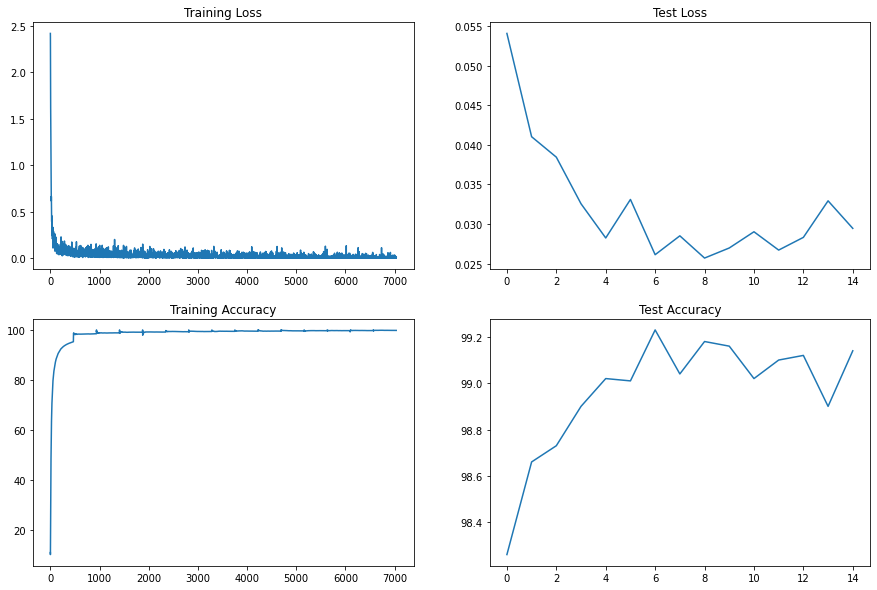

In [10]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

plot_result()

## Results:

<b>Parameters:</b> 6,765

<b>Best Train Accuracy:</b> 99.81

<b>Best Test Accuracy:</b> 99.23

<b>Analysis:</b>
Batch normalization reduces internal covariate shift by controlling the mean and variance of input distributions helping in faster convergence. From the above network result we can abserve that its overfitting and with the help of dropout and image augmentation we can reduce this overfitting and acheive the required target